In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

# Загрузка и подготовка данных

In [2]:
instruments = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'EOSUSDT']
files = ['close.csv', 'open.csv', 'low.csv', 'high.csv', 'volume.csv']
columns = ['close', 'open', 'low', 'high', 'volume']

In [3]:
series_per_ccys = {k: [] for k in instruments}

for file in files:
    frame = pd.read_csv('data/' + file,parse_dates=True,index_col=0)
    for instrument in instruments:
        series_per_ccys[instrument].append(frame[instrument])
df_per_ccys = {k: pd.DataFrame(series_per_ccys[k], columns).transpose() for k in instruments}
df_per_ccys['BTCUSDT'].head()

,close,open,low,high,volume
2020-01-01 00:00:00,7186.68,7184.42,7183.14,7196.25,51.642812
2020-01-01 00:01:00,7184.03,7186.68,7182.20,7188.06,7.248148
2020-01-01 00:02:00,7182.43,7184.03,7180.26,7184.71,11.681677
2020-01-01 00:03:00,7185.94,7182.43,7182.49,7188.94,10.025391
2020-01-01 00:04:00,7179.78,7185.94,7178.64,7185.54,14.911105


Пока что будем работать только с `BTCUSDT`:

In [4]:
df = df_per_ccys['BTCUSDT']

Добавляем доходности:

In [5]:
df['return'] = (df['open'] - df['close']) / (df['open'])
df.head()

,close,open,low,high,volume,return
2020-01-01 00:00:00,7186.68,7184.42,7183.14,7196.25,51.642812,-0.000315
2020-01-01 00:01:00,7184.03,7186.68,7182.20,7188.06,7.248148,0.000369
2020-01-01 00:02:00,7182.43,7184.03,7180.26,7184.71,11.681677,0.000223
2020-01-01 00:03:00,7185.94,7182.43,7182.49,7188.94,10.025391,-0.000489
2020-01-01 00:04:00,7179.78,7185.94,7178.64,7185.54,14.911105,0.000857


Объявляем функцию для ресеплирования:

In [6]:
def resample(freq, dataframe: pd.DataFrame) -> pd.DataFrame:
  return dataframe.groupby(pd.Grouper(freq=freq)).agg({'open':'first', 'close':'last', 'high':'max', 'low':'min', 'volume': 'sum', 'return': 'std'}).rename(columns={'return': 'vol'})

Пока что будем работать только с часовыми данными, выбрасываем точки, где не было торгов, волатильность за час получаем умножением на корень из количества периодов (60):

In [7]:
df_1h = resample('1h', df)
df_1h['return'] = (df_1h['open'] - df_1h['close']) / (df_1h['open'])
df_1h['vol'] = df_1h['vol'] * np.sqrt(60.0)
df_1h = df_1h.dropna()
df_1h = df_1h[df_1h['volume'] != 0]
df_1h.head()

,open,close,high,low,volume,vol,return
2020-01-01 00:00:00,7184.42,7177.02,7196.25,7175.46,511.814901,0.002777,0.001030
2020-01-01 01:00:00,7177.02,7216.27,7230.00,7175.71,883.052603,0.004275,-0.005469
2020-01-01 02:00:00,7216.27,7242.85,7244.87,7211.41,655.156809,0.002741,-0.003683
2020-01-01 03:00:00,7242.85,7225.01,7245.00,7220.00,783.724867,0.003049,0.002463
2020-01-01 04:00:00,7225.01,7217.27,7230.00,7215.03,467.812578,0.001920,0.001071


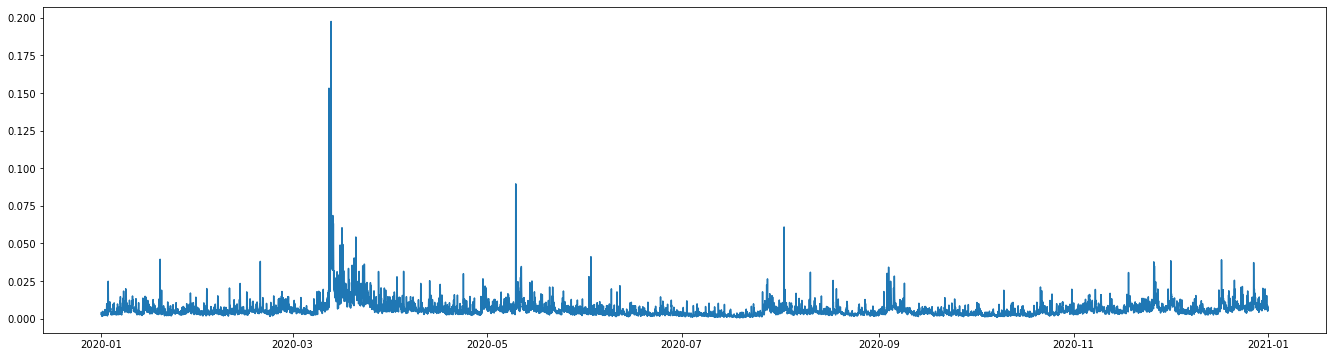

In [8]:
plt.figure(figsize=(23,6))
plt.plot(df_1h['vol'])
plt.show()

Объявляем метрику `RMSPE`:

In [9]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Historical Average

In [10]:
def calculate_HA(realized_vol, l_history):
  data = np.full(realized_vol.size, np.nan)

  for i in range(l_history, len(realized_vol)):
    history = realized_vol[i - l_history: i]
    data[i] = np.mean(history)

  return pd.Series(data=data, index=realized_vol.index)

Ищем оптимальное значение перебором:

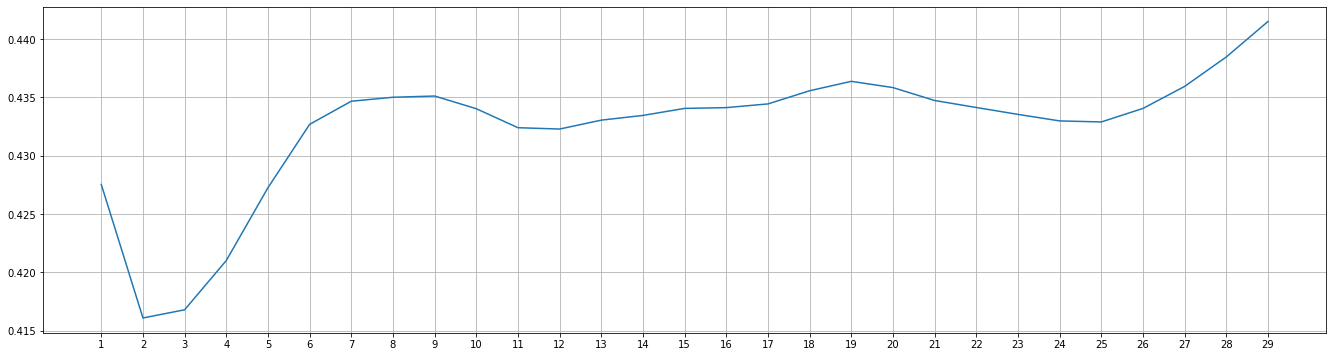

In [11]:
l_history = []
values = []

for l in range(1, 30):
    l_history.append(l)
    values.append(rmspe(df_1h['vol'], calculate_HA(df_1h['vol'], l)))

plt.figure(figsize=(23,6))
plt.plot(l_history, values)
plt.xticks(l_history)
plt.grid()
plt.show()

In [12]:
ha_vol = calculate_HA(df_1h['vol'], 2)

Из графика видно, что оптимальное значение `l_history = 2`

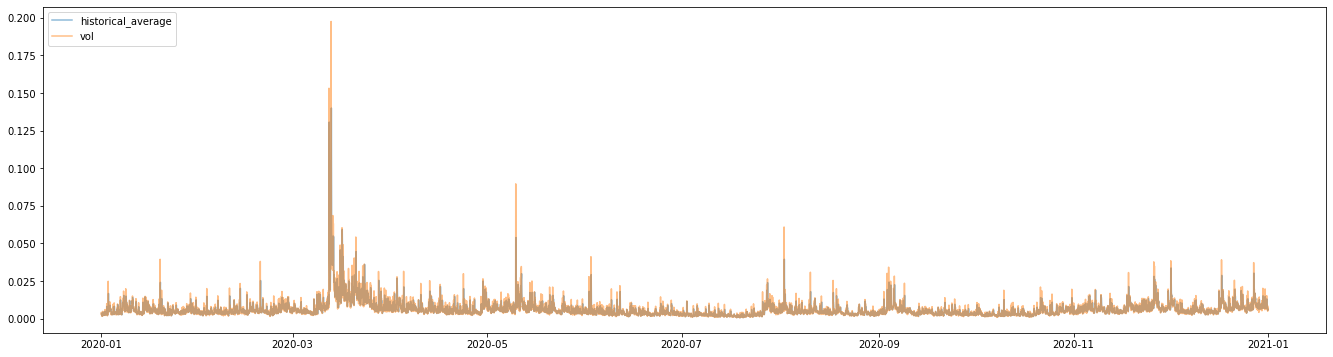

In [13]:
plt.figure(figsize=(23,6))
plt.plot(ha_vol, alpha=0.5, label="historical_average")
plt.plot(df_1h['vol'], alpha=0.5, label="vol")
plt.legend(loc="upper left")
plt.show()

In [14]:
rmspe(df_1h['vol'], calculate_HA(df_1h['vol'], 2))

0.41610374004389444

# Exponentially Weighted Moving Average

In [15]:
def ewma(data, alpha):
  sum = 0.0
  for x in data:
    sum = sum * alpha + x * (1.0-alpha)
  return sum

In [16]:
def calculate_EWMA(realized_vol, l_history, alpha):
  data = np.full(realized_vol.size, np.nan)

  for i in range(l_history, len(realized_vol)):
    history = realized_vol[i - l_history: i]
    data[i] = ewma(history, alpha)

  return pd.Series(data=data, index=realized_vol.index)


In [17]:
alpha_min = None
l_min = None
value_min = None

for l in range (2, 10):
  for alpha in np.arange(0.0, 1.0, 0.05):
    value = rmspe(df_1h['vol'], calculate_EWMA(df_1h['vol'], l, alpha))
    if value_min is None or value_min > value:
        value_min = value
        l_min = l
        alpha_min = alpha
print("Optimal l: ", l_min, " alpha,", alpha_min, " value:", value_min)

Optimal l:  6  alpha, 0.75  value: 0.32251579278333725


In [18]:
ewma_vol = calculate_EWMA(df_1h['vol'], l_min, alpha_min)

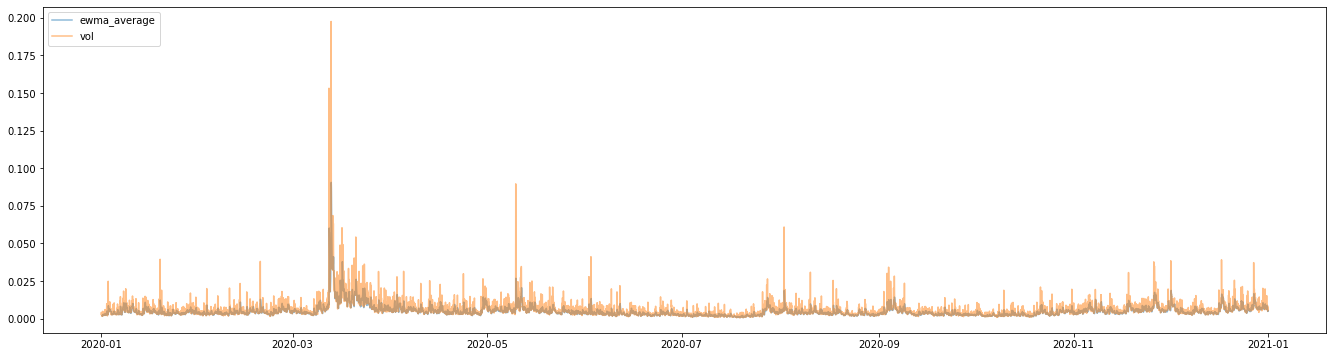

In [19]:
plt.figure(figsize=(23,6))
plt.plot(ewma_vol, alpha=0.5, label="ewma_average")
plt.plot(df_1h['vol'], alpha=0.5, label="vol")
plt.legend(loc="upper left")
plt.show()

In [20]:
rmspe(df_1h['vol'], ewma_vol)

0.32251579278333725

# GARCH

In [21]:
!pip install arch

You should consider upgrading via the '/home/lantalex/bin/python -m pip install --upgrade pip' command.


Смотрим автокорреляцию, из нее видно, что имеет смысл рассматривать не более 30 последних периодов для предсказания волатильности следующего:

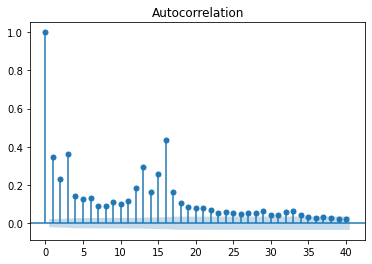

In [22]:
plot_acf(df_1h['vol']**2)
None

In [23]:
from arch import arch_model
from arch.__future__ import reindexing
from math import sqrt

def garch(returns):

  scaling_const = 100.0 / returns.std()

  am = arch_model(scaling_const * returns,
                  mean='Constant',
                  vol='Garch', p=1, q=1,
                  dist='skewstudent')
  
  res = am.fit(options={'ftol' : 1e-2}, update_freq=0, disp='off')

  forecasts = res.forecast(horizon=1)

  return sqrt(float(forecasts.variance.iloc[-1])) / scaling_const

In [24]:
def calculate_GARCH(returns, l_history):
  data = np.full(returns.size, np.nan)

  for i in range(l_history, len(returns)):
    history = returns[i - l_history: i]
    data[i] = garch(history)

  return pd.Series(data=data, index=returns.index)

In [25]:
garch_vol = calculate_GARCH(df_1h['return'], 30)

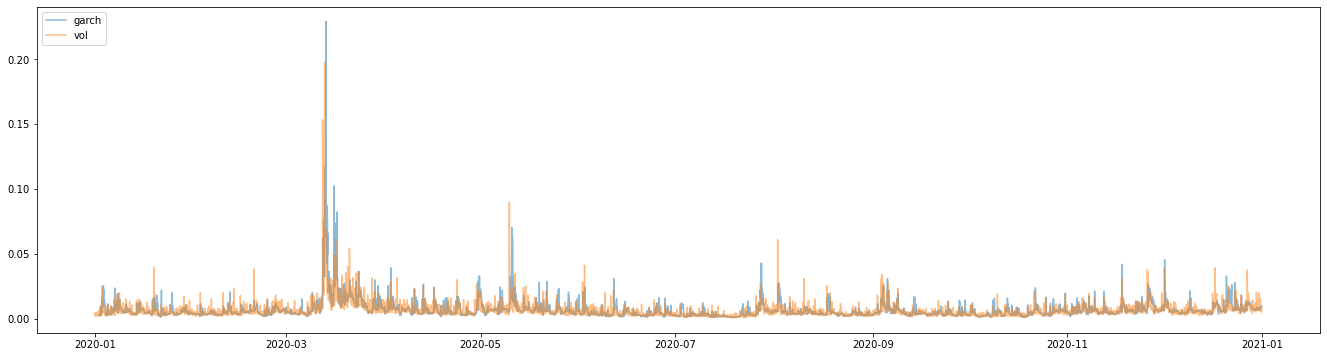

In [26]:
plt.figure(figsize=(23,6))
plt.plot(garch_vol, alpha=0.5, label="garch")
plt.plot(df_1h['vol'], alpha=0.5, label="vol")
plt.legend(loc="upper left")
plt.show()

In [27]:
rmspe(df_1h['vol'], garch_vol)

0.6991278337228573

#### Сводная таблица

In [28]:
print("GARCH: ", rmspe(df_1h['vol'], garch_vol))
print("EWMA: ", rmspe(df_1h['vol'], ewma_vol))
print("HA: ", rmspe(df_1h['vol'], ha_vol))

GARCH:  0.6991278337228573
EWMA:  0.32251579278333725
HA:  0.41610374004389444


Плохие результаты GARCH не удивительны ввиду того, что простое умножение минутной волатильности на корень из количества периодов статистически переоценивает волатильность за период - см. статью https://www.sas.upenn.edu/~fdiebold/papers/paper18/dsi.pdf

(простые решения HA/EWMA не подвержены такому эффекту)